In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
@author: M Arshad Zahangir Chowdhury

Identify experiments, plot roc, pr curve, grad cam maps etc.

Date: Aug 15, 2022

Additional analysis to plot the scores of some of the experimental spectra.

"""

%matplotlib inline 

import sys
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
from ipywidgets import interactive
import seaborn as sns  #heat map
import glob # batch processing of images

if '../../' not in sys.path:
    sys.path.append('../../')

import math
from scipy import signal
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve 
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

import itertools

from vocnet.misc.utils import classifier_internals
from vocnet.misc.utils import clf_post_processor


# from vocnet.spectral_datasets.IR_datasets import IR_data
# from vocnet.spectral_datasets.IR_datasets import spectra_to_img
from vocnet.spectral_datasets.THz_datasets import THz_data

from vocnet.misc.aperture import publication_fig
from vocnet.misc.voc_net_utils import multiclass_roc_auc_score
from vocnet.misc.voc_net_utils import plot_raw_scores
from vocnet.misc.voc_net_utils import simple_spectrum_fig
from vocnet.misc.voc_net_utils import simple_plot_raw_scores

from vocnet.misc.voc_net_utils import plot_sequential_group_prediction



import tensorflow as tf
from tensorflow.keras import datasets, layers, models


# GPU_mem_limit=1.0
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=GPU_mem_limit*1000.0)])

#     except RuntimeError as e:
#         print(e)        


# !pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow.keras import regularizers

from vocnet.models.voc_net_models import get_callbacks
from vocnet.models.voc_net_models import get_optimizer
from vocnet.models.voc_net_models import compile_and_fit


from vocnet.models.voc_net_models import C1f1k3_AP1_D12
from vocnet.models.voc_net_models import C1f1k3_MP1_D12

from vocnet.models.voc_net_models import C2f1k3_AP1_D12
from vocnet.models.voc_net_models import C2f1k3_AP1_D48_D12
from vocnet.models.voc_net_models import C2f1k3_AP2_D48_D12

from vocnet.models.voc_net_models import C2f3k3_AP1_D48_D12
from vocnet.models.voc_net_models import C2f3k3_AP1_D6_D12

from vocnet.models.voc_net_models import C1f1k3_AP1_RD50_D12
from vocnet.models.voc_net_models import C1f1k3_AP1_D48_RL1_D12
from vocnet.models.voc_net_models import C2f3k3_AP1_D48_RD50_D12
from vocnet.models.voc_net_models import C2f3k3_AP1_D48_RL1_D12
from vocnet.models.voc_net_models import C2f3k3_AP1_D48_RL1_RD50_D12

    

from tensorflow import keras
import keras_tuner as kt

import random


#Set random seed
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.random.set_seed(42)  
tf.random.get_global_generator().reset_from_seed(42)
np.random.seed(42)
random.seed(42)



# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")



2022-08-15 18:35:02.191065: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


GPU found


2022-08-15 18:35:03.133714: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-08-15 18:35:03.163341: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2022-08-15 18:35:03.163396: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-08-15 18:35:03.168796: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-08-15 18:35:03.168888: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-08-15 18:35:03.170165: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10

In [2]:
s = THz_data(resolution=0.016, verbosity = False)
s.load_THz_data()
# s.dataset_info()
X = s.spectra
y = s.targets

X=np.expand_dims(X,-1)

In [3]:
global_indices=range(0, s.n_spectra)
print(global_indices)

range(0, 1968)


In [4]:
#split intro train and test set

#seeds used 123,237, 786
from sklearn.model_selection import train_test_split

TRAIN_SIZE=0.70
TEST_SIZE=1-TRAIN_SIZE

x_train, x_test, y_train, y_test, train_indices, test_indices = train_test_split(X, y, global_indices, train_size=TRAIN_SIZE,
                                                   test_size=TEST_SIZE,
                                                   random_state=786,
                                                   stratify=y
                                                   )

print("All:", np.bincount(y) / float(len(y))*100  )
print("Training:", np.bincount(y_train) / float(len(y_train))*100  )
print("Testing:", np.bincount(y_test) / float(len(y_test))*100  )


All: [8.33333333 8.33333333 8.33333333 8.33333333 8.33333333 8.33333333
 8.33333333 8.33333333 8.33333333 8.33333333 8.33333333 8.33333333]
Training: [8.35148874 8.35148874 8.35148874 8.35148874 8.35148874 8.35148874
 8.35148874 8.2788671  8.35148874 8.35148874 8.2788671  8.2788671 ]
Testing: [8.29103215 8.29103215 8.29103215 8.29103215 8.29103215 8.29103215
 8.29103215 8.46023689 8.29103215 8.29103215 8.46023689 8.46023689]


# build the VOC-Net Model

In [5]:
def voc_net():

    model = models.Sequential()

    # C1 Convolutional Layer
    model.add(layers.Conv1D(filters = 3 , kernel_size=3, activation='relu', input_shape=(229, 1), name = 'C1') )

    # S2 Subsampling Layer
    model.add(layers.AveragePooling1D(pool_size = 2, strides = 2, padding = 'valid', name = 'S2'))
    
    # C3 Convolutional Layer
    model.add(layers.Conv1D(filters = 3 , kernel_size=3, activation='relu', name = 'C3') )

    # Flatten the CNN output to feed it with fully connected layers
    model.add(layers.Flatten())
    
    model.add(layers.Dense(48, activation='relu')) 
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(12))  # number of dense layer would be equal to number of classess
    


    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=[
              tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True, name='SparseCatCrossentropy'),
              'accuracy'])
    
    model.summary()
    
    return model

In [6]:

s.load_experiments()
Xexp = s.exp_spectra
yexp = s.exp_targets
SpectraFrame = pd.DataFrame(s.exp_spectra)
SpectraFrame['labels'] = [s.labels[i] for i in s.exp_targets]
SpectraFrame['targets'] =  s.exp_targets
spectraframe = SpectraFrame 
Xexp = np.expand_dims(Xexp,-1)
print(yexp)

print(s.labels)
print([s.labels[i] for i in s.exp_targets])
print(s.list_filenames)

Number of Experimental Compounds: 6
Number of Spectrum: 6
Total Number of Spectra: 36
Sample Size of training data: 229
Rows discarded: 22
[10 10 10 10 10 10  2  2  2  2  2  2  1  1  1  1  1  1  0  0  0  0  0  0
  8  8  8  8  8  8 11 11 11 11 11 11]
['CH3Cl', 'CH3OH', 'HCOOH', 'H2CO', 'H2S', 'SO2', 'OCS', 'HCN', 'CH3CN', 'HNO3', 'C2H5OH', 'CH3CHO']
['C2H5OH', 'C2H5OH', 'C2H5OH', 'C2H5OH', 'C2H5OH', 'C2H5OH', 'HCOOH', 'HCOOH', 'HCOOH', 'HCOOH', 'HCOOH', 'HCOOH', 'CH3OH', 'CH3OH', 'CH3OH', 'CH3OH', 'CH3OH', 'CH3OH', 'CH3Cl', 'CH3Cl', 'CH3Cl', 'CH3Cl', 'CH3Cl', 'CH3Cl', 'CH3CN', 'CH3CN', 'CH3CN', 'CH3CN', 'CH3CN', 'CH3CN', 'CH3CHO', 'CH3CHO', 'CH3CHO', 'CH3CHO', 'CH3CHO', 'CH3CHO']
['Ethanol 2 Torr WDL 8 Notch.csv', '1-Sweep CH3CH2OH v3 220-330-16 Torr.csv', '1-Sweep CH3CH2OH v3 220-330-8 Torr.csv', 'v2Paper Ethanol 1 Torr.csv', 'Ethanol 4 Torr WDL 8 Notch Shift.csv', 'Ethanol 8 Torr WDL 8 Notch Shift.csv', 'Formic Acid 1 Torr WDL 5 Notch Shift.csv', 'Formic Acid 2 Torr WDL 5 Notch Shift.

In [7]:
model = voc_net()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv1D)                  (None, 227, 3)            12        
_________________________________________________________________
S2 (AveragePooling1D)        (None, 113, 3)            0         
_________________________________________________________________
C3 (Conv1D)                  (None, 111, 3)            30        
_________________________________________________________________
flatten (Flatten)            (None, 333)               0         
_________________________________________________________________
dense (Dense)                (None, 48)                16032     
_________________________________________________________________
dropout (Dropout)            (None, 48)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                5

In [8]:
# run on CPU for reproducibility, best epoch is 4.
with tf.device('/CPU:0'):
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='SparseCatCrossentropy', patience=5)
    history = model.fit(x_train, y_train, epochs=4, validation_data=(x_test, y_test), callbacks=[stop_early])



2022-08-15 18:35:13.948318: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-15 18:35:13.966150: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3600000000 Hz


Epoch 1/4
44/44 [==============================] - 1s 13ms/step - loss: 1.1818 - SparseCatCrossentropy: 1.1559 - accuracy: 0.6645 - val_loss: 0.1511 - val_SparseCatCrossentropy: 0.1514 - val_accuracy: 0.9662
Epoch 2/4
44/44 [==============================] - 0s 9ms/step - loss: 0.1868 - SparseCatCrossentropy: 0.1832 - accuracy: 0.9622 - val_loss: 0.0871 - val_SparseCatCrossentropy: 0.0870 - val_accuracy: 0.9712
Epoch 3/4
44/44 [==============================] - 0s 9ms/step - loss: 0.1351 - SparseCatCrossentropy: 0.1361 - accuracy: 0.9731 - val_loss: 0.0404 - val_SparseCatCrossentropy: 0.0404 - val_accuracy: 0.9932
Epoch 4/4
44/44 [==============================] - 0s 9ms/step - loss: 0.0993 - SparseCatCrossentropy: 0.0971 - accuracy: 0.9746 - val_loss: 0.0544 - val_SparseCatCrossentropy: 0.0550 - val_accuracy: 0.9966


Text(0, 0.5, 'Accuracy')

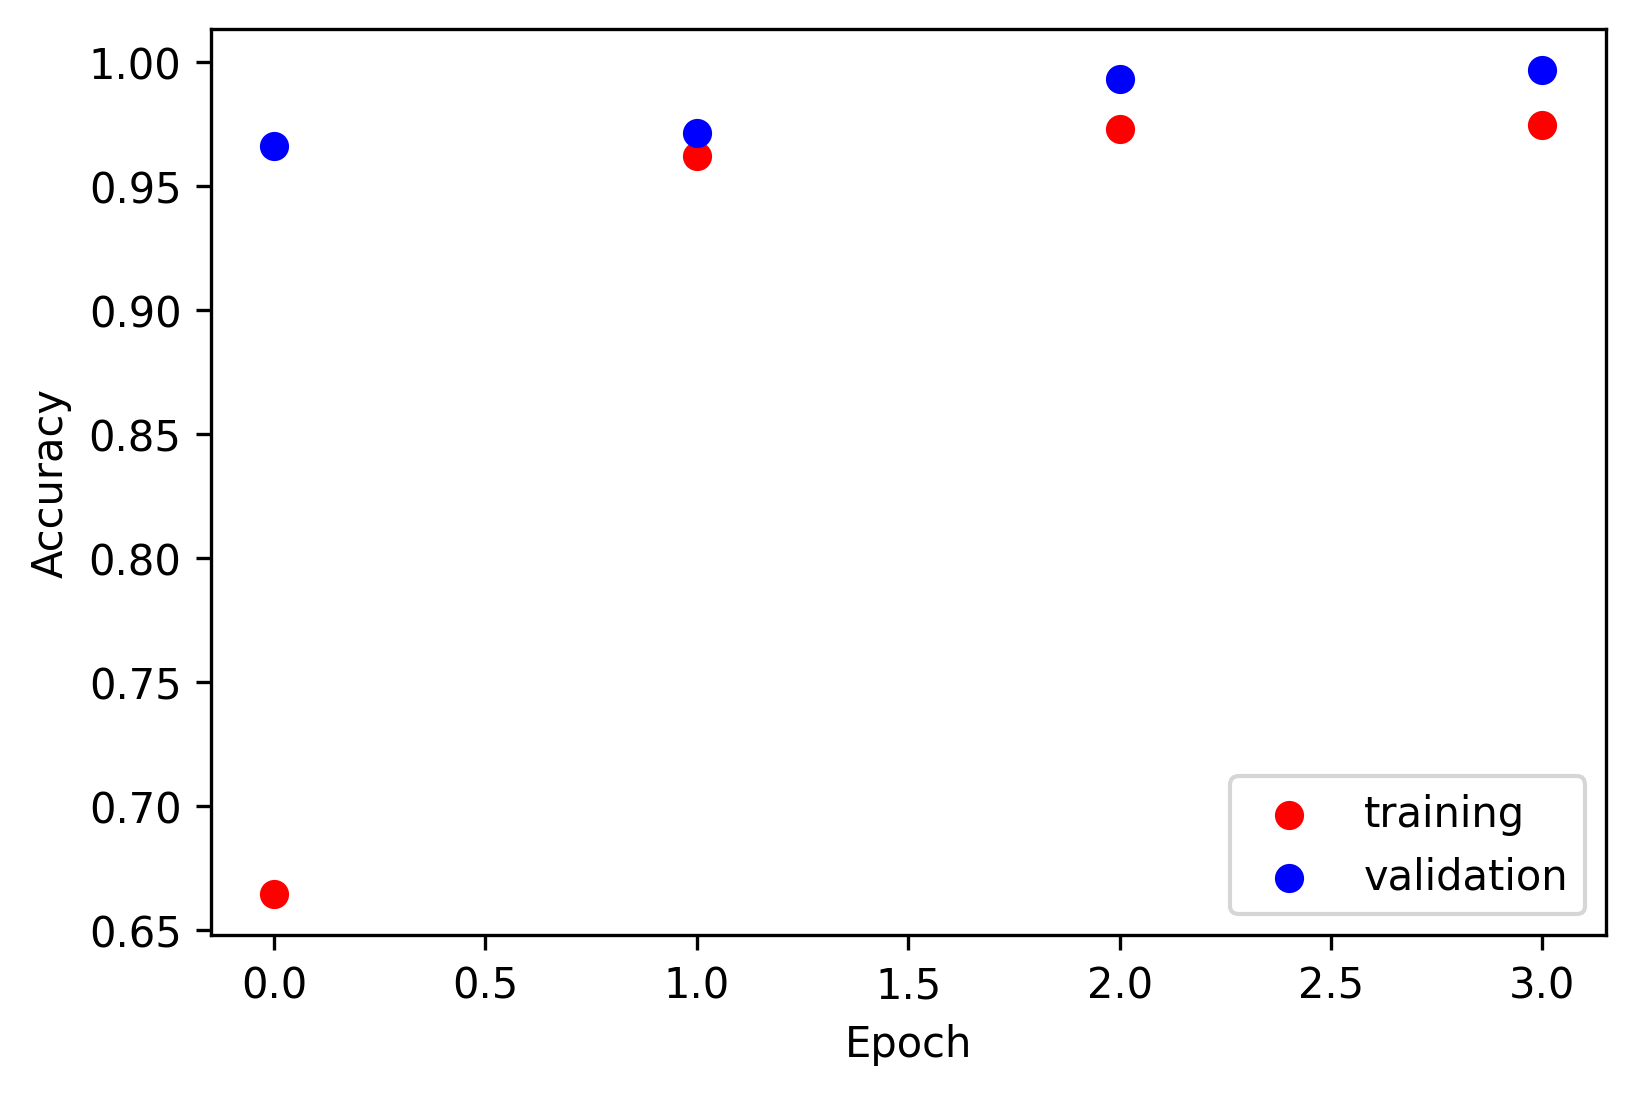

In [9]:
plt.figure(dpi=300)
plt.scatter(history.epoch,history.history['accuracy'], color = 'red', label = 'training')
plt.scatter(history.epoch,history.history['val_accuracy'], color = 'blue', label = 'validation')
plt.legend(loc=4)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.savefig(r'RESULTS/results_figures/accuracies.png', bbox_inches='tight')

Text(0, 0.5, 'Sparse categorical crossentropy loss')

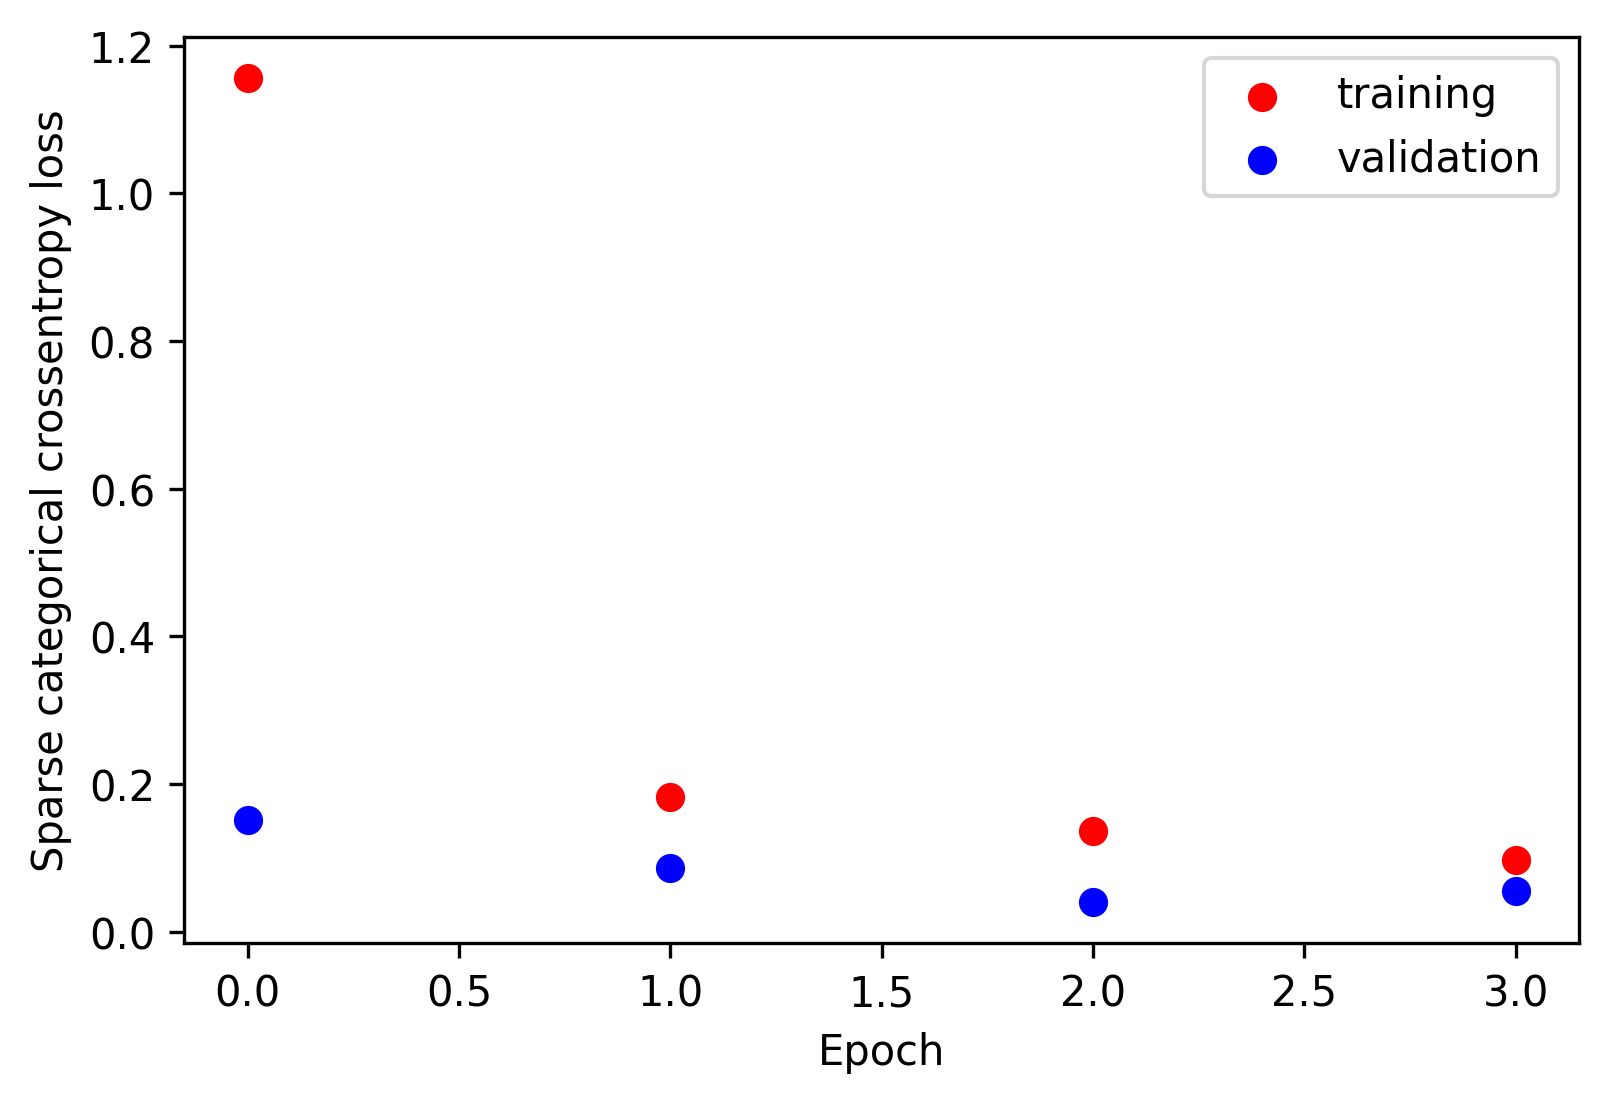

In [10]:
plt.figure(dpi=300)
plt.scatter(history.epoch,history.history['SparseCatCrossentropy'], color = 'red', label = 'training')
plt.scatter(history.epoch,history.history['val_SparseCatCrossentropy'],color = 'blue', label = 'validation')
plt.legend(loc=1)
plt.xlabel('Epoch')
plt.ylabel('Sparse categorical crossentropy loss')
# plt.savefig(r'RESULTS/results_figures/sparse_cat_losses.png', bbox_inches='tight')

# training accuracies vs epoch

In [11]:
model.evaluate(x_test,  y_test, verbose=2)

2022-08-15 18:35:19.477006: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-08-15 18:35:19.717006: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8204
2022-08-15 18:35:20.173883: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


19/19 - 1s - loss: 0.0544 - SparseCatCrossentropy: 0.0550 - accuracy: 0.9966


2022-08-15 18:35:20.637029: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


[0.05441968888044357, 0.055005963891744614, 0.9966158866882324]

# softmax scores

In [14]:
import vocnet.misc.voc_net_utils

In [231]:
def simple_plot_raw_scores_vertical(i, predictions_array, true_label,all_unique_labels):
    def add_value_label(x_list,y_list):
        for i in range(0, len(x_list)):
            plt.text(i,y_list[i],round(y_list[i],2),fontsize=25,ha='center', va='bottom')
    
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(12),all_unique_labels)

    scoreplot = plt.bar(range(12), predictions_array[i], color="#777777")
    
    plt.ylim([0, 1.05])
    predicted_label = np.argmax(predictions_array[i])
    plt.xticks(fontsize = 25);
    plt.tick_params(axis = 'y', direction = 'out', which = 'major', labelsize=25) # , pad =-335
    
    plt.xlabel('label',fontsize = 25)
    plt.ylabel('softmax score',fontsize = 25)
    scoreplot[predicted_label].set_color('red')
    scoreplot[true_label].set_color('blue')
    
    add_value_label(range(12),predictions_array[i])
    
#     for rect, label in zip(scoreplot.patches, all_unique_labels):
#         height = rect.get_height()
#         plt.annotate(
#             rect.get_x() + rect.get_width() / 2, height + 5, all_unique_labels, ha="center", va="bottom"
#         )

In [240]:
def simple_plot_raw_scores_cam(i, predictions_array, true_label,all_unique_labels):
    def add_value_label(x_list,y_list):
        for j in range(0, len(x_list)):
            plt.text(y_list[j],j,round(y_list[j],2),fontsize=7,ha='left', va='center')
    
    true_label = true_label[i]
    plt.grid(False)
    plt.yticks(range(12),all_unique_labels)

    scoreplot = plt.barh(range(12), predictions_array[i], color="#777777")
    
    plt.xlim([0, 1.15])
    predicted_label = np.argmax(predictions_array[i])
    plt.yticks(fontsize = 7);
    plt.tick_params(axis = 'y', direction = 'out') # , pad =-335
    
    plt.ylabel('label')
    plt.xlabel('softmax score')
    scoreplot[predicted_label].set_color('red')
    scoreplot[true_label].set_color('blue')
    add_value_label(range(12),predictions_array[i])

In [241]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [242]:
predictions = probability_model.predict(x_test)


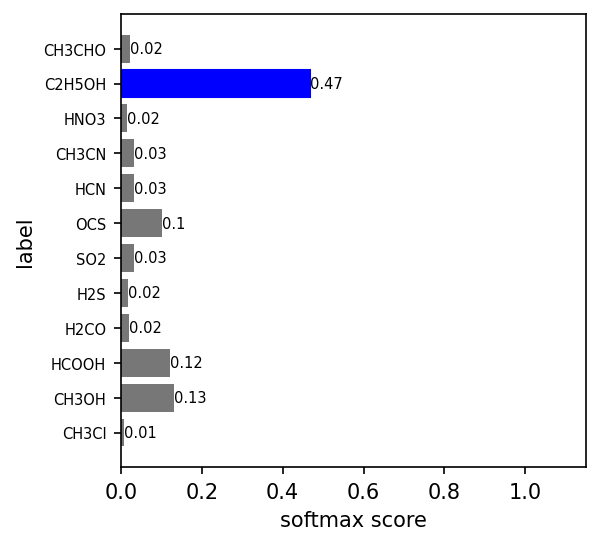

In [243]:
i=3
plt.figure(figsize=(4,4),dpi=150)
simple_plot_raw_scores_cam(i, predictions, y_test,s.labels)

In [180]:
pred_y=np.argmax(model.predict(x_test), axis=-1)

In [181]:
pred_y_train=np.argmax(model.predict(x_train), axis=-1)

In [182]:
predictions_on_train = probability_model.predict(x_train)

In [183]:
pred_y_exp=np.argmax(model.predict(Xexp), axis=-1)
print(pred_y_exp)

[10 10 10 10 10 10  2  2  2  2  2  2  1  1  1  1  2  1  0  0  0  0  0  0
  8  8  8  8  8  8 11 11 11 11 11 11]


In [184]:
predictions_exp = probability_model.predict(Xexp) # softmax scores for experiment


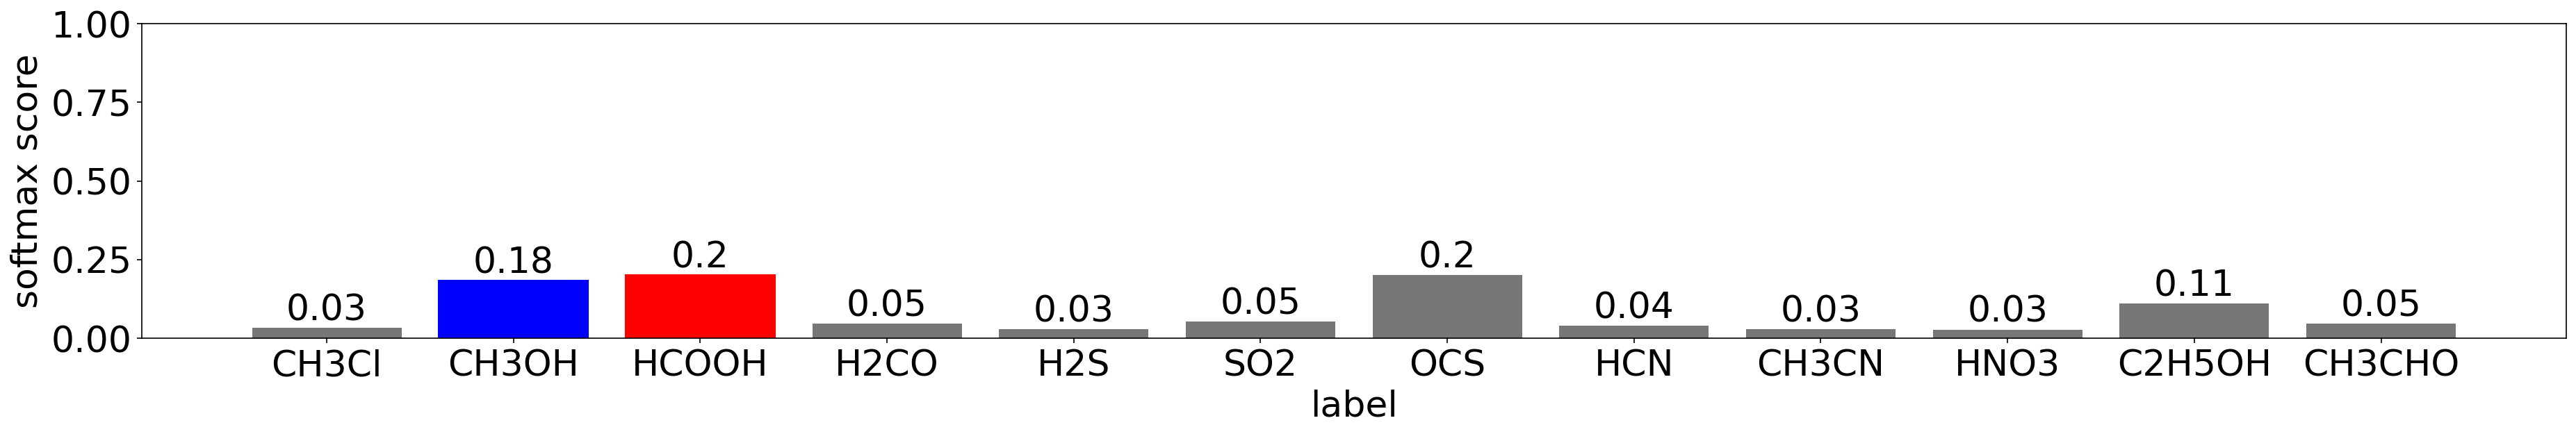

In [192]:
i=16
plt.figure(figsize=(30,4),dpi=150)
simple_plot_raw_scores_vertical(i, predictions_exp, yexp,s.labels)

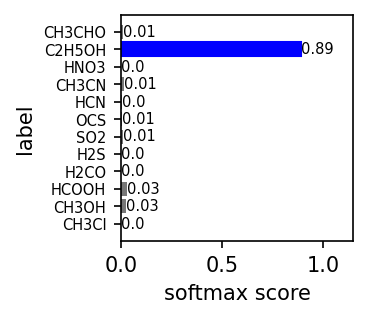

In [250]:
i=0
plt.figure(figsize=(2,2),dpi=150)
simple_plot_raw_scores_cam(i, predictions_exp, yexp,s.labels)
plt.savefig(r'RESULTS/class_activation_maps/scores_CAM_exp' + str(i) + '.png', bbox_inches='tight')

# Notebook ends